# 用Pandas來計算常見技術指標 - RSI
我們這次來計算看看RSI

In [1]:
#載入套件庫與讀入資料
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

db = sqlite3.connect('TWStock_2')
tsmc = pd.read_sql(con=db,sql='SELECT * FROM "2330"')

In [2]:
#清理資料
#我們需要成交股數、開盤價、最高價、最低價、收盤價的資料
#並使用Date當作我們的索引值

tsmc.index = pd.to_datetime(tsmc['Date'])
tsmc = tsmc[['成交股數','開盤價','最高價','最低價','收盤價']]
tsmc.columns = ['Volume','Open','High','Low','Close']
tsmc['Close'] = pd.to_numeric(tsmc['Close'])
tsmc = tsmc['2019-01-01':]

## RSI
根據[維基百科](https://www.wikiwand.com/zh-hant/%E7%9B%B8%E5%B0%8D%E5%BC%B7%E5%BC%B1%E6%8C%87%E6%95%B8):
相對強弱指數（Relative Strength Index，RSI），一藉比較價格升降運動以表達價格強度的技術分析工具。 其計算方法為
設每天向上變動為U，向下變動為D。
- 在價格上升的日子: U = 當日收盤價 - 昨日收盤價, D =0
- 在價格下跌的日子: U = 0 , D = 昨日收盤價 - 當日收盤價
有了U和D的值之後，我們需要計算U以及D的平均值，這邊的平均值是使用n天的指數移動平均(EMA)，則我們可以計算出相對強度

$$RS = \frac{EMA(U,n)}{EMA(D,n)}$$
有了相對強度，我們就可以計算出RSI

$$RSI = (1 - \frac{1}{1+RS}) \times 100\%$$
根據威爾德（英語：J. Welles Wilder）的測量結果，當n=14時，指數最具代表性。他指出當某證券的RSI升至70時，代表該證券已被超買（Overbought），投資者應考慮出售該證券。相反，當證券RSI跌至30時，代表證券被超賣（Oversold），投資者應購入該證券。 

In [4]:
tsmc['Dif'] = tsmc['Close'].diff()

In [6]:
def cal_U(num):
    if num >= 0:
        return num
    else:
        return 0
def cal_D(num):
    num = -num
    return cal_U(num)

tsmc['U'] = tsmc['Dif'].apply(cal_U)
tsmc['D'] = tsmc['Dif'].apply(cal_D)
tsmc['ema_U'] = tsmc['U'].ewm(span=14).mean()
tsmc['ema_D'] = tsmc['D'].ewm(span=14).mean()
tsmc['RS'] = tsmc['ema_U'].div(tsmc['ema_D'])
tsmc['RSI'] = tsmc['RS'].apply(lambda rs:rs/(1+rs) * 100)

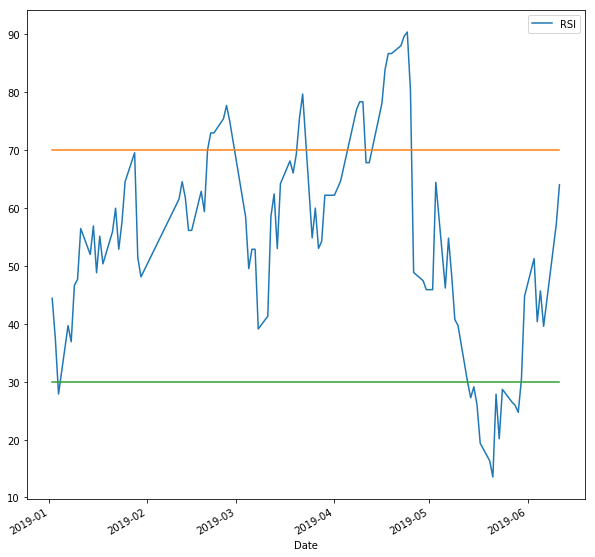

In [29]:
#最後來畫畫圖
#來畫個圖吧
plt.figure(figsize=(10,10))
tsmc['RSI'].plot()
plt.plot(tsmc.index,[70]*len(tsmc.index))
plt.plot(tsmc.index,[30]*len(tsmc.index))
plt.legend()
plt.show()
